# Building a Language Model Using Histogram N-Gram Analysis

This project introduces language modeling by focusing on generating pop song lyrics. You will implement histogram N-gram models using the Natural Language Toolkit (NLTK) to analyze and understand word frequencies and distributions. This approach helps reveal linguistic patterns and repetitive structures characteristic of pop music

In [ ]:
import warnings
import time
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import string
import time
from collections import OrderedDict

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

def warn(*args, **kwargs):
  pass

warnings.warn = warn
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/victorcata/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/victorcata/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Helper functions

In [3]:
def preprocess_string(s):
  # Remove all non-word characters (everything except numbers and letters)
  s = re.sub(r"[^\w\s]", '', s)
  # Replace all runs of whitespaces with no space
  s = re.sub(r"\s+", '', s)
  # replace digits with no space
  s = re.sub(r"\d", '', s)
  
  return s

## Language modeling

Language modeling is a foundational concept within the field of natural language processing (NLP) and artificial intelligence. It involves the prediction of the likelihood of a sequence of words within a given language. This method is statistical in nature and seeks to capture the patterns, structures, and relationships that exist between words in a given text corpus.

In [4]:
song= """We are no strangers to love
You know the rules and so do I
A full commitments what Im thinking of
You wouldnt get this from any other guy
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
And if you ask me how Im feeling
Dont tell me youre too blind to see
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Weve known each other for so long
Your hearts been aching but youre too shy to say it
Inside we both know whats been going on
We know the game and were gonna play it
I just wanna tell you how Im feeling
Gotta make you understand
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you
Never gonna give you up
Never gonna let you down
Never gonna run around and desert you
Never gonna make you cry
Never gonna say goodbye
Never gonna tell a lie and hurt you"""

## Tokenization

In [5]:
def preprocess(words):
  tokens = word_tokenize(words)
  tokens = [preprocess_string(w) for w in tokens]
  return [w.lower() for w in tokens if len(w) != 0 and (w not in string.punctuation)]

tokens = preprocess(song)
print(tokens)

['we', 'are', 'no', 'strangers', 'to', 'love', 'you', 'know', 'the', 'rules', 'and', 'so', 'do', 'i', 'a', 'full', 'commitments', 'what', 'im', 'thinking', 'of', 'you', 'wouldnt', 'get', 'this', 'from', 'any', 'other', 'guy', 'i', 'just', 'wan', 'na', 'tell', 'you', 'how', 'im', 'feeling', 'got', 'ta', 'make', 'you', 'understand', 'never', 'gon', 'na', 'give', 'you', 'up', 'never', 'gon', 'na', 'let', 'you', 'down', 'never', 'gon', 'na', 'run', 'around', 'and', 'desert', 'you', 'never', 'gon', 'na', 'make', 'you', 'cry', 'never', 'gon', 'na', 'say', 'goodbye', 'never', 'gon', 'na', 'tell', 'a', 'lie', 'and', 'hurt', 'you', 'weve', 'known', 'each', 'other', 'for', 'so', 'long', 'your', 'hearts', 'been', 'aching', 'but', 'youre', 'too', 'shy', 'to', 'say', 'it', 'inside', 'we', 'both', 'know', 'whats', 'been', 'going', 'on', 'we', 'know', 'the', 'game', 'and', 'were', 'gon', 'na', 'play', 'it', 'and', 'if', 'you', 'ask', 'me', 'how', 'im', 'feeling', 'dont', 'tell', 'me', 'youre', 'too',

The frequency distribution of words in a sentence represents how often each word appears in that particular sentence. It provides a count of the occurrences of individual words, allowing you to understand which words are more common or frequent within the given sentence. 

In [8]:
fdist = nltk.FreqDist(tokens)
fdist

FreqDist({'na': 40, 'gon': 38, 'you': 37, 'never': 36, 'and': 16, 'tell': 9, 'make': 8, 'say': 8, 'a': 7, 'give': 6, ...})

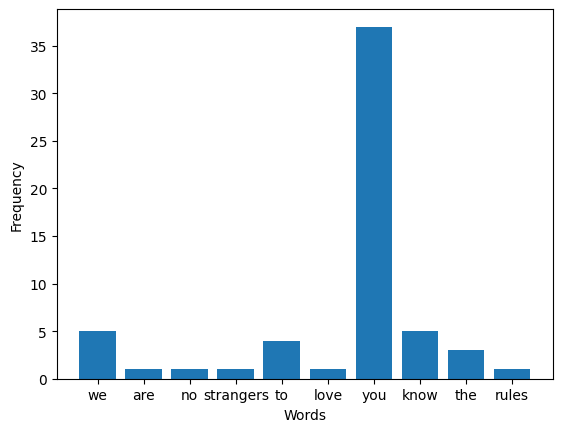

In [9]:
plt.bar(list(fdist.keys())[0:10], list(fdist.values())[0:10])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

## Unigram model

An unigram model is a simple type of language model that considers each word in a sequence independently, without taking into account the previous words. In other words, it models the probability of each word occurring in the text, regardless of what came before it. Unigram models can be seen as a special case of n-gram models, where n is 1.


Using NLTK you can normalize the frequency values by dividing them by the total count of each word to get a probability function. Now you will find the probability of each word.


Let's consider the example 'I like tiramisu but I love cheesecake more' where the unigram model is asked to predict the next word following the sequence 'I like'.

If the highest probability among all words is "I" with a probability 0.25, then according to the model, the most likely next word after 'I like' would be 'I'. However, this prediction doesn't make sense at all. This highlights a significant limitation of the unigram model—it lacks context, and its predictions are entirely dependent on the word with the highest probability "I" in this case

Even if multiple words have the same highest probabilities, it will randomly choose any one word out of all the options.

In [ ]:
# total count of words
C = sum(fdist.values())
prob_word = fdist['strangers']/C

print(f'Total num. words: {C}')
print(f'Probability of word strangers: {prob_word}')

Total num. words: 385
Probability of word strangers: 0.0025974025974025974


0.0025974025974025974

In [ ]:
vocabularity = set(tokens)